In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import random

In [2]:
sns.set()

In [3]:
#exporto columnas
M = np.genfromtxt('datos2.dat', delimiter=',', usecols=0) #magnitud
f = np.genfromtxt('datos2.dat', delimiter=',', usecols=1) #fi

In [4]:
#errores
e_in = np.genfromtxt('errores_inferiores.dat', delimiter=',', usecols=1) #puntos inferiores
e_su = np.genfromtxt('errores_superiores.dat', delimiter=',', usecols=1) #puntos superiores

In [5]:
#modelo
def model(M,fi0,M0,a):
    lista=[]
    for i in range(len(M)):
        y=0.4 * log(10) * fi0 * (10**(-0.4*(M[i]-M0)*(a+1))) * exp(-10**(-0.4*(M[i]-M0))) #schechter
        lista.append(y)
    return lista

In [6]:
#rango de M
sx = np.linspace(-23.5, -16, 100)

#valores de Blanton
sy = model(sx, fi0=0.0146, M0=-20.83, a=-1.2)

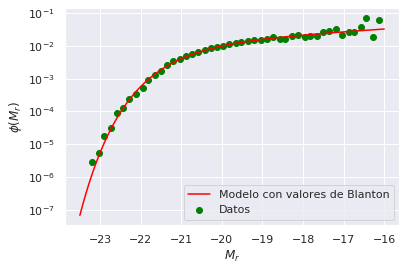

In [7]:
#los grafico con los datos
plt.plot(sx,sy, color='red', label='Modelo con valores de Blanton')
plt.scatter(M, f, color='green', label='Datos')
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi(M_r)$')
plt.legend(loc='lower right')
plt.show()

Likelihood

In [8]:
#sigmas de las gaussianas
sigma= (e_su - e_in)/2

In [9]:
def likelihood(M, f, fi0, M0, a, sigma):
    f_model = model(M,fi0,M0,a)
    
    #gaussiana centrada en el fi del modelo y sigma definido arriba:
    prob= st.norm(f_model, sigma).pdf(f)
    
    like=prob.prod()
    return like

In [10]:
#prueba con los valores de Blanton
likelihood(M,f,0.0146,-20.83,-1.2,sigma)

4.529434606468913e+121

In [11]:
#pruba con otros valores
likelihood(M,f,0.02,-21,-1,sigma)

1.3041787540153151e-238

A medida que los puntos medidos se acerquen más a los valores predichos por el modelo, es likelihood es mayor.


Priors

Para la probabilidad a priori de los parámetros se toma una distribución plana, asumiendo que no se conoce nada de los parámetros. Por lo que esta función devuelve un valor constante si se encuentra dentro de la región que se va a muestrear, mientras que es nula fuera de la región.

Para elegir los límites en los parámetros, se prueban distintos valores y se los compara con los datos. Se nota que $\phi_*$ mueve el modelo hacia arriba/abajo, $M_*$ la subida de la función en el eje de las magnitudes y $\alpha$ la pendiente de la parte lineal.

Como los parámetros no son independientes entre si, para ver si los límites que se proponen son razonables y no quedan puntos medidos fuera de ellos, se consideran todos los modelos extremos dados por esos parámetros límites.

A continuación se grafican para mostrar que los parámetros elegidos no cortan los datos.


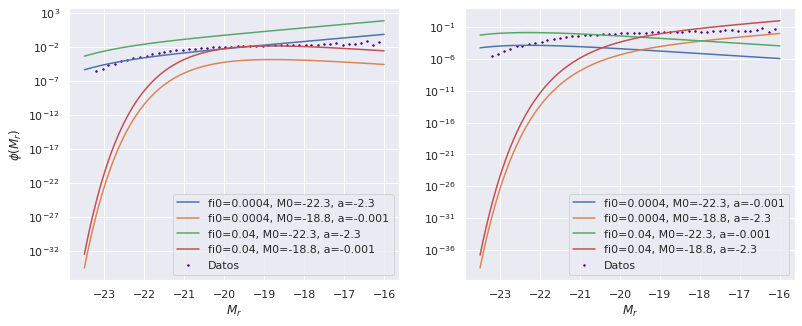

In [13]:
#grafico el modelo con distintos parámetros junto con los datos
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)   #figura con 2 filas y 2 columnas
plt.plot(sx,model(sx, fi0=0.0004, M0=-22.3, a=-2.3), label='fi0=0.0004, M0=-22.3, a=-2.3')
plt.plot(sx,model(sx, fi0=0.0004, M0=-18.8, a=-0.001), label='fi0=0.0004, M0=-18.8, a=-0.001')
plt.plot(sx,model(sx, fi0=0.04, M0=-22.3, a=-2.3), label='fi0=0.04, M0=-22.3, a=-2.3')
plt.plot(sx,model(sx, fi0=0.04, M0=-18.8, a=-0.001),  label='fi0=0.04, M0=-18.8, a=-0.001')
plt.scatter(M, f, color='indigo', s=2, label='Datos')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi(M_r)$')

plt.subplot(1,2,2)
plt.plot(sx,model(sx, fi0=0.0004, M0=-22.3, a=-0.001), label='fi0=0.0004, M0=-22.3, a=-0.001')
plt.plot(sx,model(sx, fi0=0.0004, M0=-18.8, a=-2.3), label='fi0=0.0004, M0=-18.8, a=-2.3')
plt.plot(sx,model(sx, fi0=0.04, M0=-22.3, a=-0.001), label='fi0=0.04, M0=-22.3, a=-0.001')
plt.plot(sx,model(sx, fi0=0.04, M0=-18.8, a=-2.3), label='fi0=0.04, M0=-18.8, a=-2.3')
plt.scatter(M, f, color='indigo', s=2, label='Datos')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xlabel('$M_r$')
plt.show()

In [14]:
#prior plano
def prior(fi0,M0,a):
    p=st.uniform(loc=[0.0004, -21.9, -1.9], scale=[0.0396, 2.8, 1.899])  #defino el cubo donde es constante
    r=p.pdf([fi0,M0,a]) #evaluo en el punto
    i=r.prod()   #los multiplico
    return i

In [15]:
#prueba con los valores de Blanton
prior(0.0146,-20.83,-1.2)

4.749214859799378

In [16]:
#prueba con otros valores
prior(0.0146,-20.83,-2)

0.0

Funcion de probabilidad posterior.

Se usa el teorema de Bayes

In [17]:
def posterior(M, f, fi0, M0, a, sigma=sigma):    
    pos= likelihood(M,f,fi0,M0,a,sigma) * prior(fi0,M0,a)
    return(pos)

In [18]:
#Prueba con Blanton
posterior(M, f, fi0=0.0146, M0=-20.83, a=-1.2, sigma=sigma)

2.151125813953171e+122

In [19]:
#Prueba con otros valores
posterior(M, f, fi0=2.9E-2, M0=-20.83, a=-1.2, sigma=sigma)

4.06705e-319

Se puede ver que para los valores de Blanton la probabilidad posterior es muy alta, y a medida que uno se aleja de estos valores la probabilidad posterior disminuye.
Proposal


La proposal distribution es lo que se propone para el salto de parámetros. Se asume una distribución gaussiana centrada en el paso anterior y el sigma depende del parámetro ya que debe ser el indicado para que los saltos tengan el tamaño adecuado. Se la define de la siguiente forma.


In [20]:
import functools

In [21]:
#sigmas
sig_fi0= 0.00002 
sig_M0=0.002
sig_a=0.002

proposal=functools.partial(np.random.multivariate_normal, cov = [[sig_fi0, 0 , 0], [0, sig_M0, 0], [0,0,sig_a]])

MCMC

Se realizan las cadenas, que se pueden pensar como saltos (en 3 dimensiones), cuyo nuevo paso está dado por la función proposal evaluada en el paso anterior. Se calcula la probabilidad de aceptación como el mínimo entre 1 y la razón (función posterior en el paso nuevo)/(función posterior en el paso anterior). Se genera un número aleatorio 'u' entre 0 y 1, y si u es menor a la probabilidad de aceptacion se acepta el paso.

Para elegir los parámetros iniciales de la cadena se sortean inicialmente en el rango que se definió el prior, y se le pide que elija aquellos valores que no anulen la función posterior.


In [22]:
#CADENA
post=0
while post < (1.e-8): #es como un for
    #quiero que sea un punto adentro del cubo
    fi0_inic=random.uniform(0.0004, 0.04)
    M0_inic=random.uniform(-21.9, -19.1)
    a_inic=random.uniform(-1.9, -0.001)

    post= posterior(M, f, fi0_inic, M0_inic, a_inic) #evaluo posterior en los parametros iniciales

#listas donde guardo los pasos
cadena_fi0= [fi0_inic]
cadena_M0= [M0_inic]
cadena_a= [a_inic]
posteriores=[post]
n_pasos=5000

for i in range(n_pasos):
    fi0_new, M0_new, a_new= proposal([fi0_inic, M0_inic, a_inic])

    post_new= posterior(M, f, fi0_new, M0_new, a_new) #posterior nueva

    prob_aceptacion= min(1, post_new/post)
    u=random.random()
    
    if u < prob_aceptacion : #condcion para aceptar el punto
        fi0_inic= fi0_new
        M0_inic= M0_new
        a_inic= a_new
        post=post_new
            
    cadena_fi0.append(fi0_inic)
    cadena_M0.append(M0_inic)
    cadena_a.append(a_inic)
    posteriores.append(post)



Los factores que intervinieron principalmente en las cadenas son: el ancho de los intervalos de los parámetros (priors), los sigmas dados en la proposal (pasos) y el número de pasos. Estos valores cambiaban mucho la forma de las cadenas, por lo que dificultó la tarea de elegir los correctos ya que se necesita de cierta intuición para realizarlo. Es necesario llegar a un balance entre el tamaño del salto y el ancho del intervalo, recordando que no debe ser demasiado grande ya que a grandes distancias la función posterior es nula (por el likelihood y prior), ni tampoco demasiado chico (se necesita más tiempo de cómputo o nunca llega al valor esperado).

Luego de muchos intentos, a prueba y error y gracias a la ayuda de todos nuestros compañeros se logran realizar las cadenas. Para comprobar si las cadenas muestrean correctamente y para comprobar su convergencia, se realizan distintos gráficos.

    Parámetro vs parámetro:



Text(0, 0.5, 'alfa')

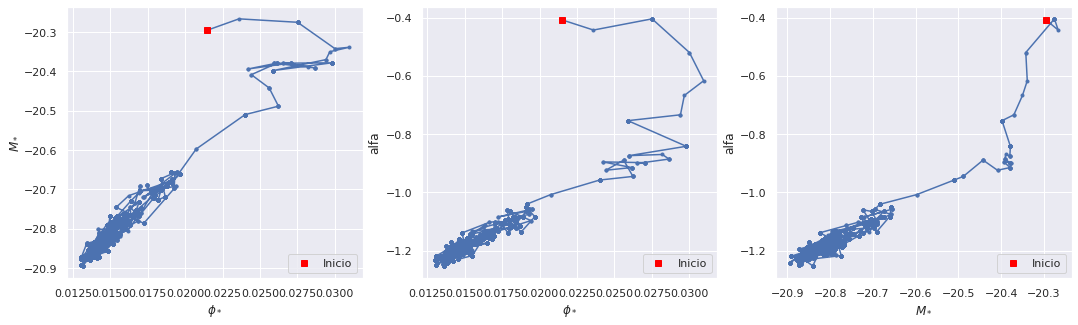

In [23]:
#parametros vs parametros
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(cadena_fi0, cadena_M0, marker='.')
plt.plot(cadena_fi0[0], cadena_M0[0], 's', color='red', label='Inicio') #parametros de inicio
plt.legend(loc='lower right')
plt.xlabel('$\phi_*$')
plt.ylabel('$M_*$')

plt.subplot(1,3,2)
plt.plot(cadena_fi0, cadena_a, marker='.')
plt.plot(cadena_fi0[0], cadena_a[0], 's', color='red', label='Inicio')
plt.legend(loc='lower right')
plt.xlabel('$\phi_*$')
plt.ylabel('alfa')

plt.subplot(1,3,3)
plt.plot(cadena_M0, cadena_a, marker='.')
plt.plot(cadena_M0[0], cadena_a[0], 's', color='red', label='Inicio')
plt.legend(loc='lower right')
plt.xlabel('$M_*$')
plt.ylabel('alfa')


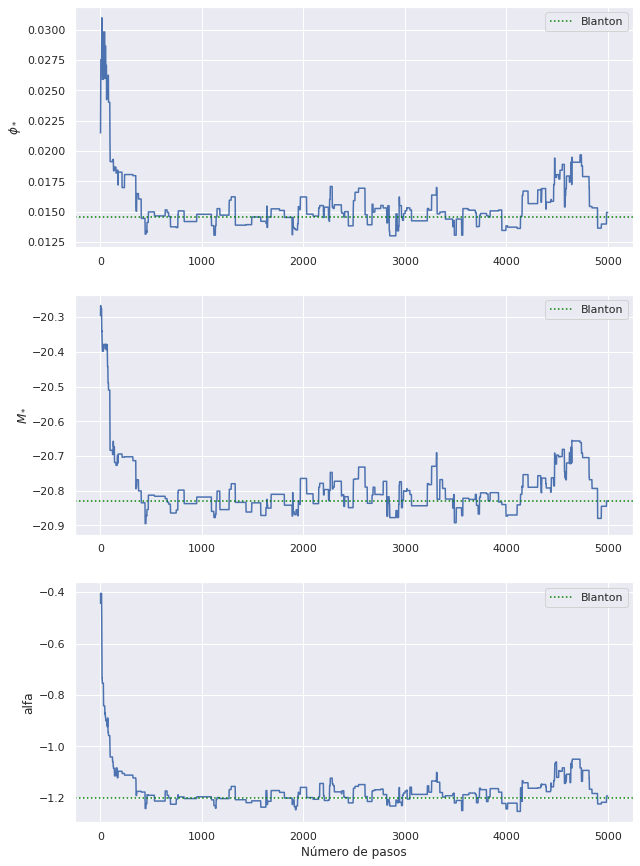

In [24]:
#en funcion de los pasos
plt.figure(figsize=(10,15))

plt.subplot(3,1,1)
plt.plot(cadena_fi0)
plt.axhline(0.0146, color='green', label='Blanton', ls="dotted") #valor esperado
plt.legend(loc='upper right')
plt.ylabel('$\phi_*$')

plt.subplot(3,1,2)
plt.plot(cadena_M0)
plt.axhline(-20.83, color='green', label='Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.ylabel('$M_*$')

plt.subplot(3,1,3)
plt.plot(cadena_a)
plt.axhline(-1.2, color='green', label='Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.xlabel('Número de pasos')
plt.ylabel('alfa')
plt.show()

Al graficar las cadenas de esta forma se puede ver que al comienzo hay un perı́odo donde las condiciones iniciales son importantes llamado “burn-in" (aproximadamente hasta el paso 500), antes de la convergencia de la cadena. Estos valores deben eliminarse. Luego de este "quemado" de la cadena, los valores quedan oscilando alrededor de un valor constante, que como se puede ver es similar al valor esperado.

    Histogramas:



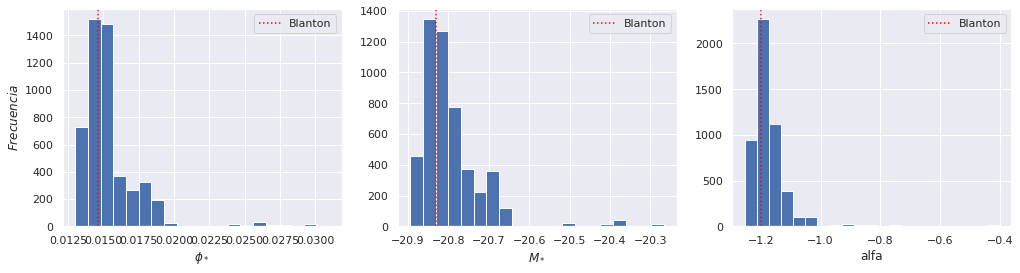

In [25]:
#Histogramas
plt.figure(figsize=(17,4))
plt.subplot(1,3,1)
plt.hist(cadena_fi0, 'doane')
plt.axvline(0.0146, color='red', label='Blanton', ls="dotted") #valor esperado
plt.legend(loc='upper right')
plt.xlabel('$\phi_*$')
plt.ylabel('$Frecuencia$')

plt.subplot(1,3,2)
plt.hist(cadena_M0, 'doane')
plt.axvline(-20.83, color='red', label='Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.xlabel('$M_*$')

plt.subplot(1,3,3)
plt.hist(cadena_a, 'doane')
plt.axvline(-1.2, color='red', label='Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.xlabel('alfa')
plt.show()

In [26]:
#corto las cadenas a partir de 1000 (quemado)
n_quemado=1000
quemado_fi0=cadena_fi0[1000:]
quemado_M0=cadena_M0[1000:]
quemado_a=cadena_a[1000:]


In [27]:
#promedio
prom_fi0=np.mean(quemado_fi0)
prom_M0=np.mean(quemado_M0)
prom_a=np.mean(quemado_a)

print('fi0=',prom_fi0)
print('M0=',prom_M0)
print('a=',prom_a)

fi0= 0.015172974428062508
M0= -20.806520342346982
a= -1.1804200770033613




Se ve que los valores obtenidos son similares a los de Blanton, por lo que la cadena sería un buen estimador de los parámetros y está cumpliendo con lo que se quería. En el proximo punto se realizan varias cadenas y se vuelven a calcular estos valores.
